In [ ]:
    import pandas as pd
    import numpy as np
    import torch 
    import torch.nn as nn
    import seaborn as sns
    from matplotlib import pyplot as plt
    import h5py
    import io
    from PIL import Image
    from sklearn.preprocessing import StandardScaler
    from torch.utils.data import Dataset
    import os

In [159]:
dir = "isic-2024-challenge"
df = pd.read_csv(f"clean-metadata.csv")
df_target1 = df[df['target'] == 1]
df_target0 = df[df['target'] == 0]
df_target0_sampled = df_target0.sample(frac=0.003, random_state=42)
print(len(df_target0_sampled), len(df_target1))
df = pd.concat([df_target1, df_target0_sampled]).reset_index(drop=True)
df = df.sample(frac=1)
train_img = f"{dir}/train-image/image"
train_hdf5 = f"{dir}/train-image.hdf5"
df.head()

1150 383


,Unnamed: 0,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,...,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,tbp_lv_dnn_lesion_confidence
1436,328935,ISIC_8223638,0,IP_4758182,30.0,female,anterior torso,3.09,TBP tile: close-up,3D: white,...,1.083944,1.484740,0.347594,50,-115.423218,1466.994629,71.161530,Memorial Sloan Kettering Cancer Center,CC-BY,99.986780
1330,371055,ISIC_9255425,0,IP_0135517,50.0,female,head/neck,2.92,TBP tile: close-up,3D: white,...,2.199666,2.282208,0.164474,170,69.739807,1435.931641,-10.155212,Memorial Sloan Kettering Cancer Center,CC-BY,99.999452
160,182078,ISIC_4586629,1,IP_2608498,60.0,female,lower extremity,7.57,TBP tile: close-up,3D: white,...,2.141814,1.391973,0.342831,85,-296.151123,184.107697,-30.268738,"Frazer Institute, The University of Queensland...",CC-BY,99.990511
561,157662,ISIC_3984360,0,IP_0400658,65.0,male,posterior torso,2.65,TBP tile: close-up,3D: XP,...,1.764299,1.897516,0.355263,35,-122.844543,1217.755249,132.775879,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,99.313736
966,265365,ISIC_6652019,0,IP_1767934,45.0,male,lower extremity,3.40,TBP tile: close-up,3D: XP,...,3.845308,2.410564,0.282297,40,-265.434082,479.067261,132.559875,University Hospital of Basel,CC-BY-NC,100.000000


In [160]:
numeric_cols = [
    "age_approx",
    "clin_size_long_diam_mm",
    "tbp_lv_A",
    "tbp_lv_Aext",
    "tbp_lv_B",
    "tbp_lv_Bext",
    "tbp_lv_C",
    "tbp_lv_Cext",
    "tbp_lv_H",
    "tbp_lv_Hext",
    "tbp_lv_L",
    "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA",
    "tbp_lv_deltaB",
    "tbp_lv_deltaL",
    "tbp_lv_deltaLB",
    "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border",
    "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL",
    "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis",
    "tbp_lv_symm_2axis_angle",
    "tbp_lv_x",
    "tbp_lv_y",
    "tbp_lv_z",
    "tbp_lv_dnn_lesion_confidence",
]
categoric_cols = ['sex', 'anatom_site_general', "tbp_lv_location", "tbp_lv_location_simple"]

df_categorical = pd.get_dummies(df[categoric_cols], drop_first=True)
df_numeric = df[numeric_cols].copy()

scaler = StandardScaler()
df_numeric[numeric_cols] = scaler.fit_transform(df_numeric[numeric_cols])

processed = pd.concat([df_numeric, df_categorical], axis=1)

clean_df = df.copy()
for col in processed.columns:
    clean_df[col] = processed[col]

In [ ]:
    def decode_isic_image(isic_id, file_path, num_channels=3, as_array=False):
        """
        Decodes an ISIC image from an HDF5 file.

        The HDF5 file is expected to store images with keys corresponding to their ISIC IDs.
        The image can be stored either as encoded bytes (JPEG, PNG, etc.) or as a raw NumPy array.

        Parameters:
            isic_id (str): The ISIC identifier referencing the image in the HDF5 file.
            file_path (str): The path to the HDF5 file.
            num_channels (int): The expected number of channels in the image. For example, 1 for grayscale,
                                3 for RGB, or 4 for RGBA.
            as_array (bool): If True, returns a NumPy array; otherwise returns a PIL Image (default).

        Returns:
            PIL.Image.Image or numpy.ndarray: The decoded image.

        Raises:
            ValueError: If the image cannot be found or decoded, or if the image channels do not
                        match the expected number.
        """
        # Open the HDF5 file and retrieve the image using its ISIC ID.
        with h5py.File(file_path, "r") as hf:
            try:
                # Adjust this line if the images are stored under a subgroup (e.g., hf['images'][isic_id]).
                data = hf[isic_id][()]
            except KeyError:
                raise ValueError(f"Image with ISIC ID '{isic_id}' not found in the HDF5 file.")

        # Case 1: The data is stored as encoded image bytes.
        if isinstance(data, bytes):
            image = Image.open(io.BytesIO(data))

        # Case 2: The data is stored as a raw NumPy array.
        elif isinstance(data, np.ndarray):
            # If the image is grayscale (2D array) and one channel is expected:
            if data.ndim == 2 and num_channels == 1:
                image = Image.fromarray(data, mode='L')
            # For color images, we expect a 3D array.
            elif data.ndim == 3:
                if data.shape[2] == num_channels:
                    if num_channels == 1:
                        # Squeeze the extra dimension for grayscale.
                        image = Image.fromarray(data.squeeze(), mode='L')
                    elif num_channels == 3:
                        image = Image.fromarray(data, mode='RGB')
                    elif num_channels == 4:
                        image = Image.fromarray(data, mode='RGBA')
                    else:
                        # For uncommon channel counts, fall back to default conversion.
                        image = Image.fromarray(data)
                else:
                    raise ValueError(f"Expected {num_channels} channels, but found {data.shape[2]} channels in the image data.")
            else:
                raise ValueError("Unsupported image data shape in the HDF5 file.")

        # Case 3: Attempt to convert any other type to bytes and decode.
        else:
            try:
                data_bytes = bytes(data)
                image = Image.open(io.BytesIO(data_bytes))
            except Exception as e:
                raise ValueError("Could not decode image from the HDF5 file data.") from e

        if as_array:
            return np.array(image)
        else:
            return image
        
    decoded_image = decode_isic_image("ISIC_0096034", train_hdf5, num_channels=3, as_array=False)
    decoded_image.show()

In [162]:
class SkinLesionData(Dataset):
    def __init__(self, csv_file, img_dir, hdf5_path, transform=None):
        self.df = csv_file
        self.img_dir = img_dir
        self.transform = transform
        self.hdf5_path = hdf5_path
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        isic_id = row["isic_id"]
        label = int(row["target"])
        
        image = decode_isic_image(isic_id, self.hdf5_path, num_channels=3, as_array=False)

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [163]:
import torchvision.transforms as T

train_transforms = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.3),
    T.RandomRotation(45),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    T.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    T.RandomPerspective(distortion_scale=0.2, p=0.3),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [164]:
from torch.utils.data import DataLoader, random_split

dataset = SkinLesionData(csv_file=clean_df, img_dir=train_img, hdf5_path=train_hdf5, transform=train_transforms)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


In [ ]:
import torchvision.models as models

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
for param in model.parameters():
    param.requires_grad = False
# Unfreeze last two blocks
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True


model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(512, 1)
)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

512


c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


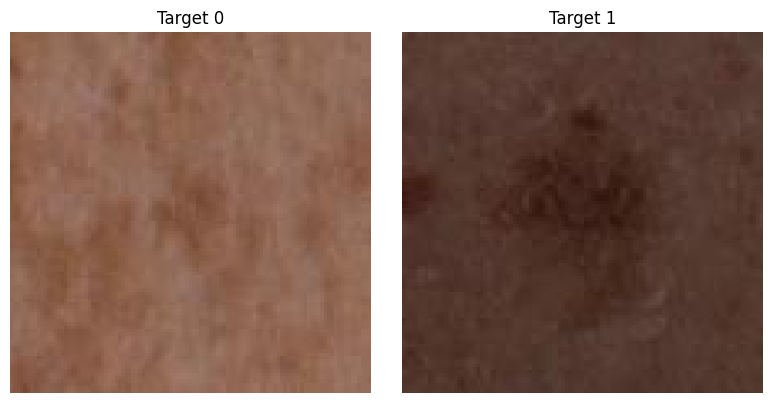

In [175]:
sample_0 = df[df['target'] == 0].iloc[0]
sample_1 = df[df['target'] == 1].iloc[0]


img_0 = decode_isic_image(sample_0['isic_id'], train_hdf5, num_channels=3, as_array=False)
img_1 = decode_isic_image(sample_1['isic_id'], train_hdf5, num_channels=3, as_array=False)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_0)
plt.title("Target 0")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_1)
plt.title("Target 1")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Get all convolutional layers in the model
conv_layers = [module for module in model.modules() if isinstance(module, nn.Conv2d)]

# Lists to store activations
activations_0 = []
activations_1 = []

# Hook function to capture activations
def hook_fn(module, input, output):
    activations.append(output.detach())

# Register hooks for all Conv2d layers
hooks = []
for layer in conv_layers:
    hooks.append(layer.register_forward_hook(hook_fn))

# Preprocess images (convert to tensor and normalize)
def preprocess(img):
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0).to(device)

# Process images through model
with torch.no_grad():
    # Clear activations and process first image
    activations = []
    _ = model(preprocess(img_0))
    activations_0 = [act.cpu().numpy() for act in activations]
    
    # Clear activations and process second image
    activations = []
    _ = model(preprocess(img_1))
    activations_1 = [act.cpu().numpy() for act in activations]

# Remove hooks
for hook in hooks:
    hook.remove()

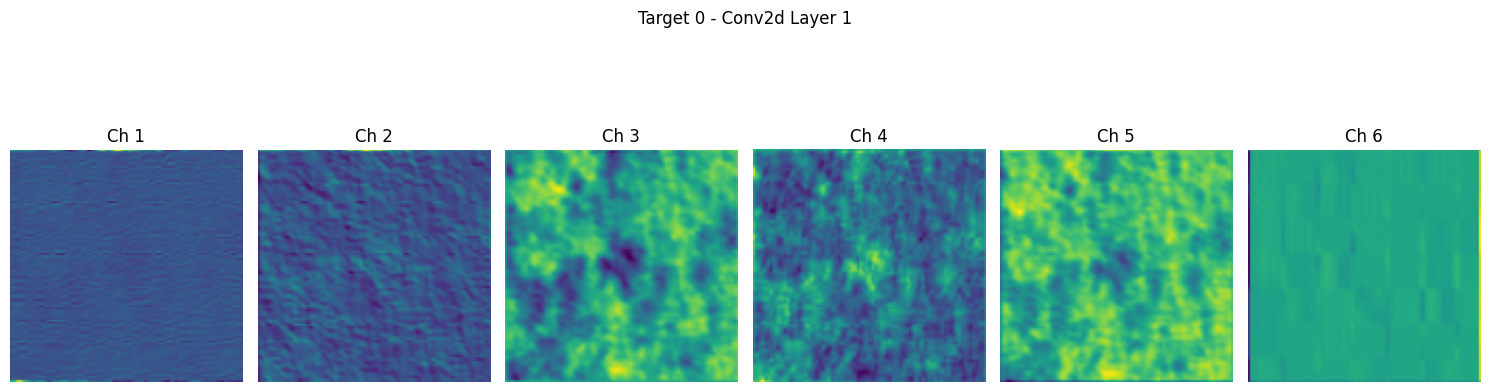

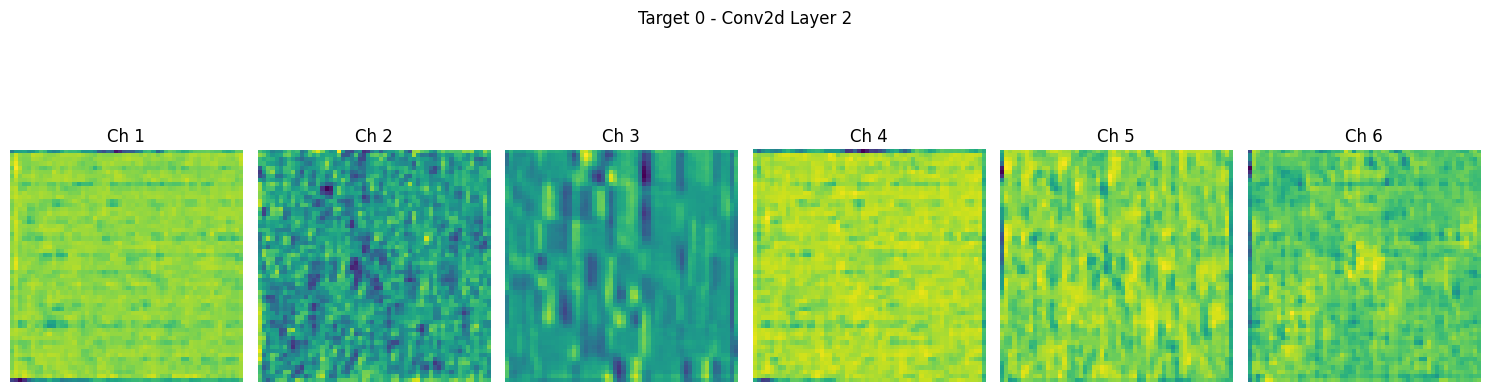

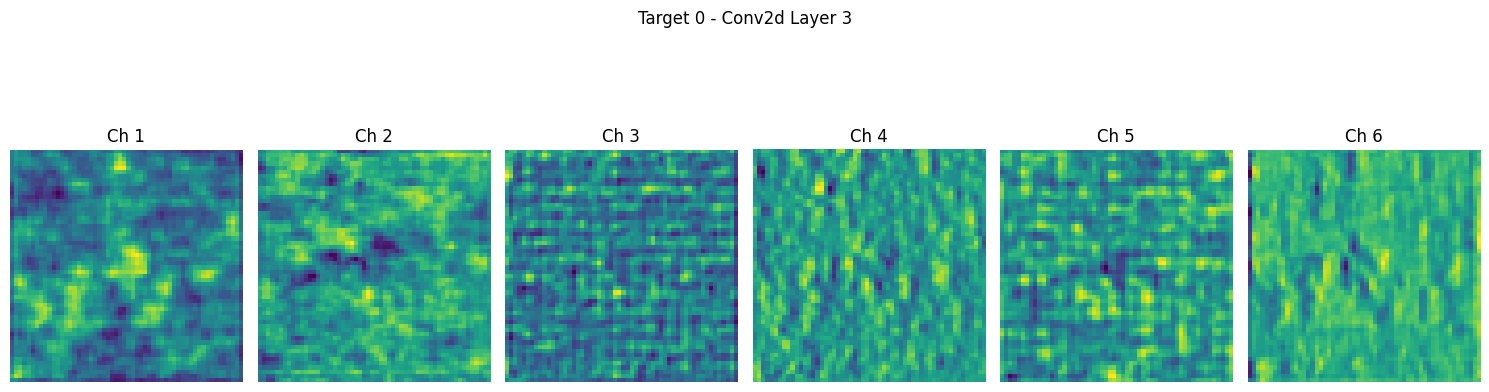

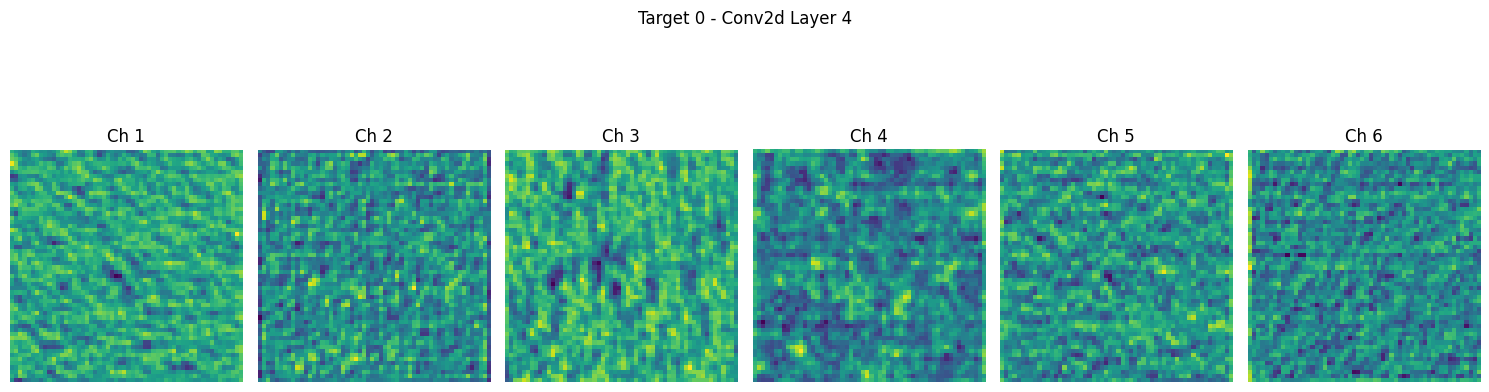

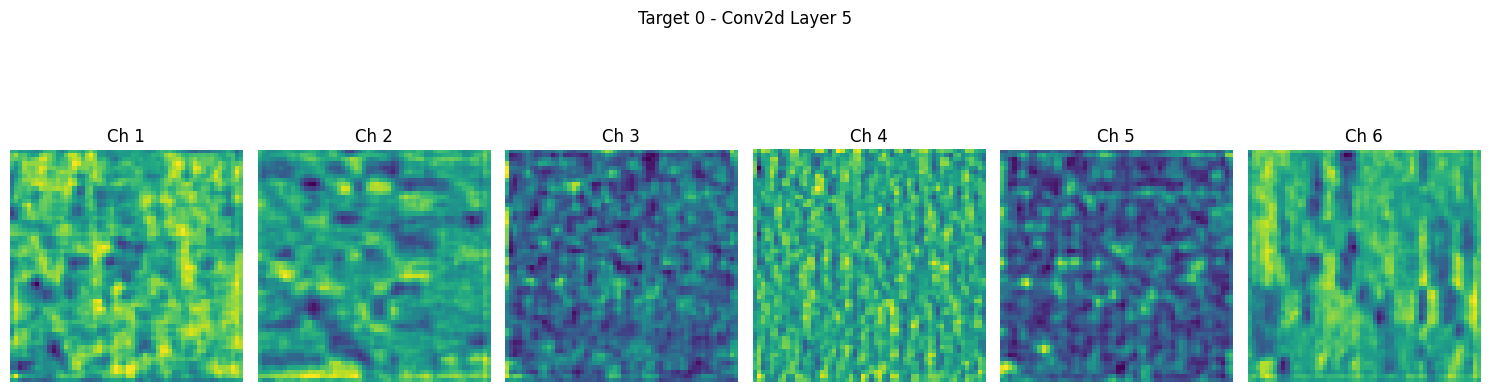

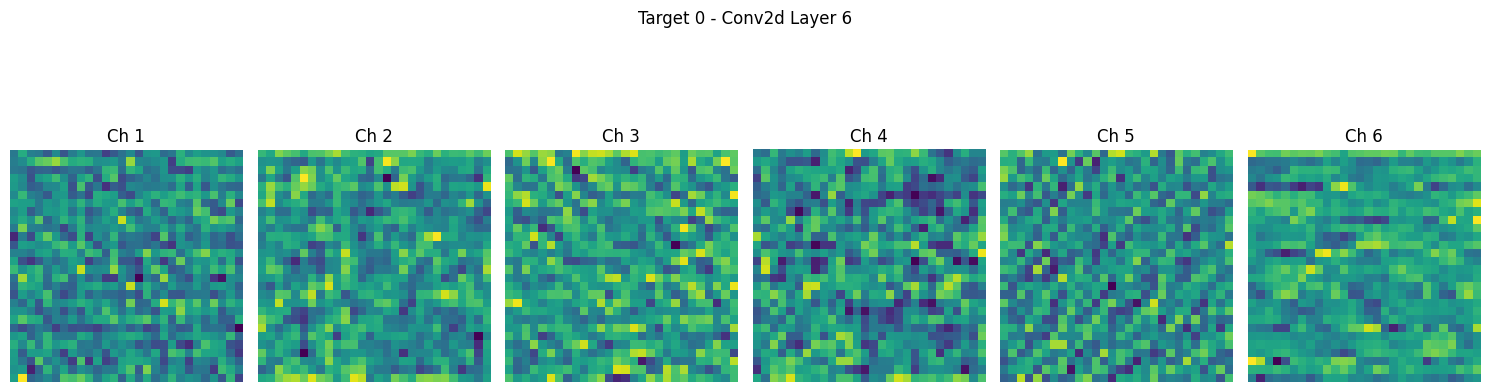

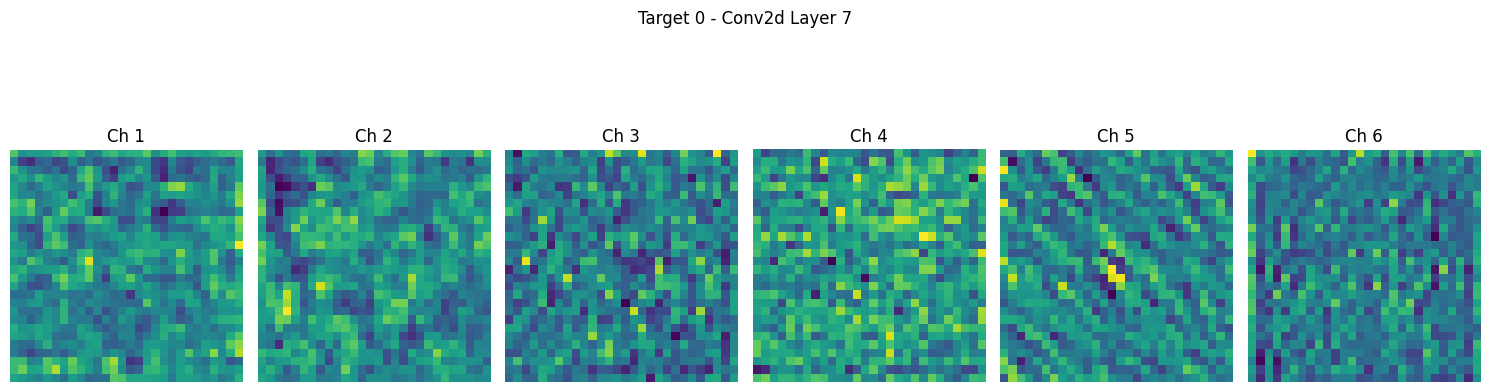

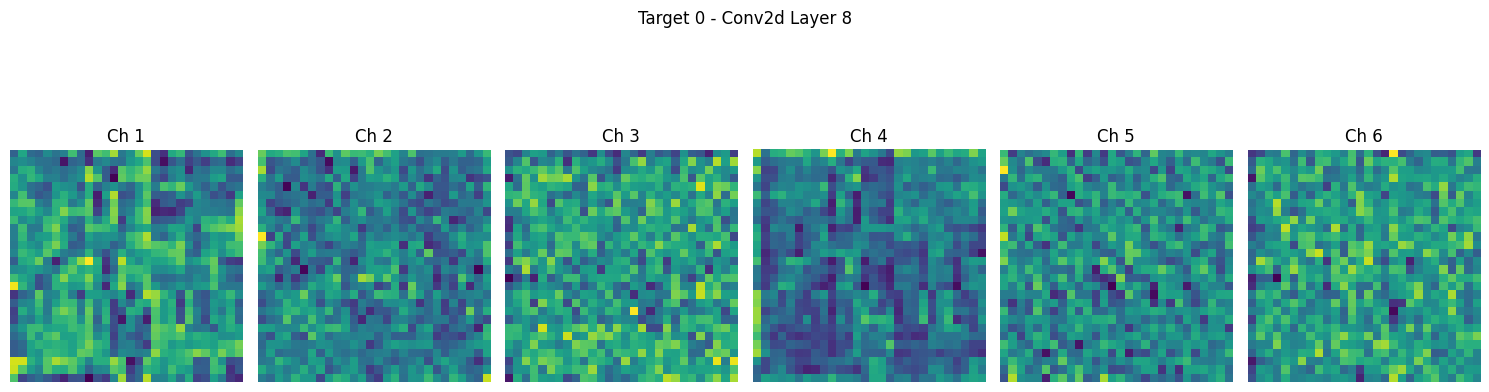

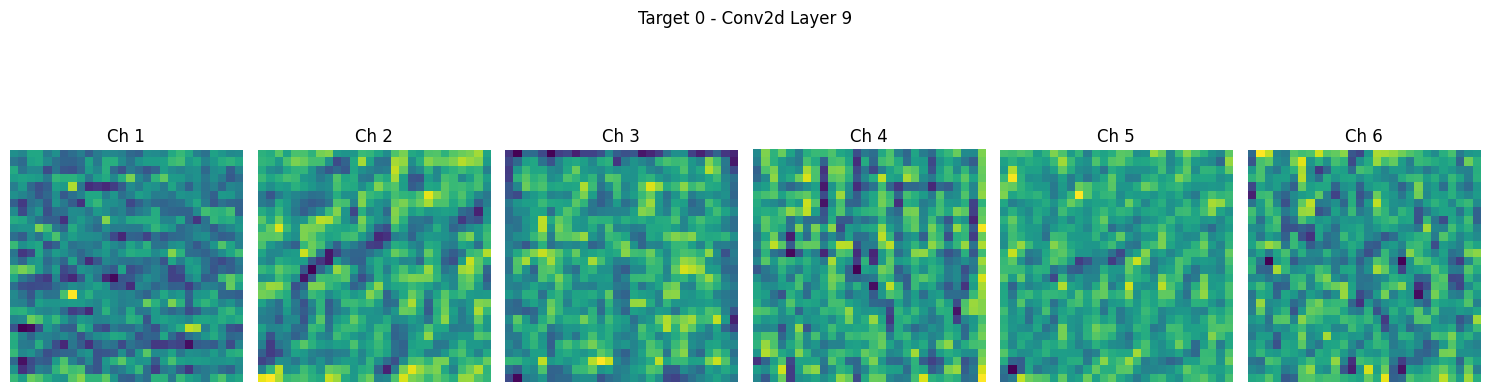

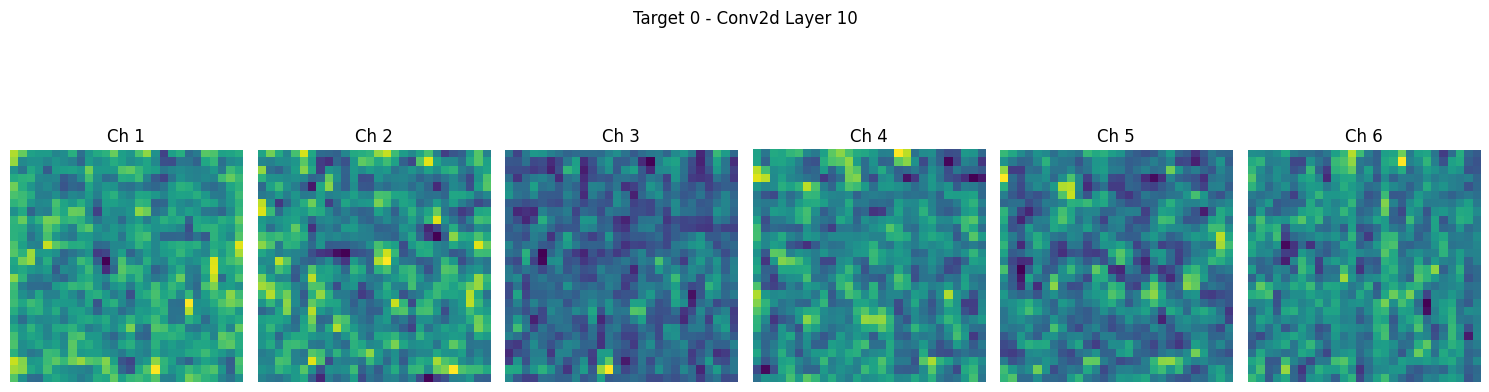

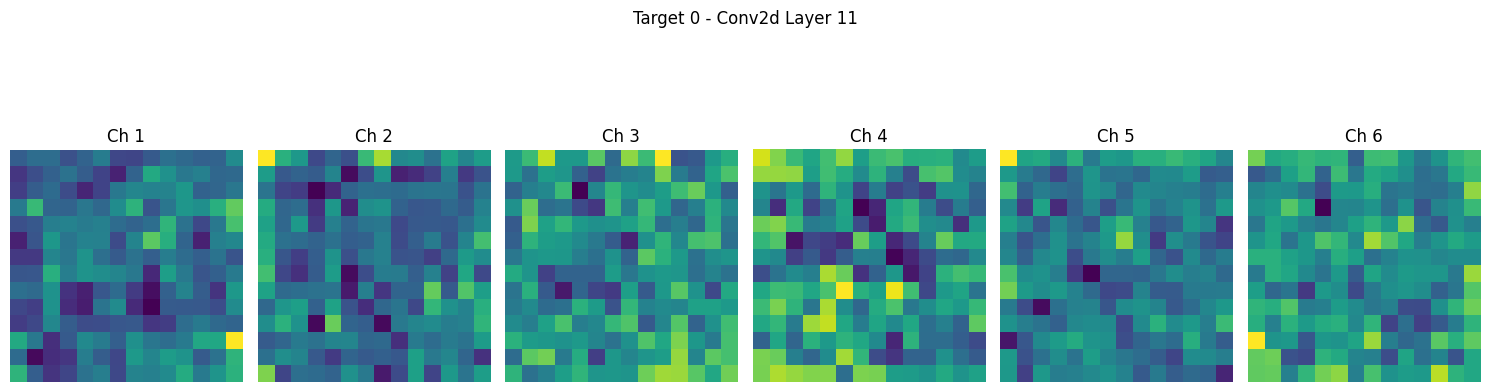

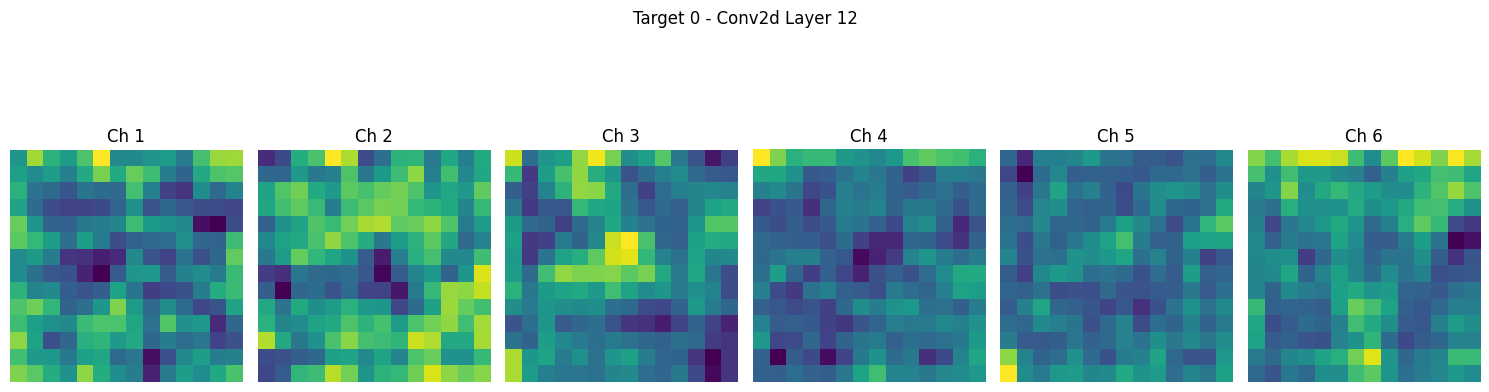

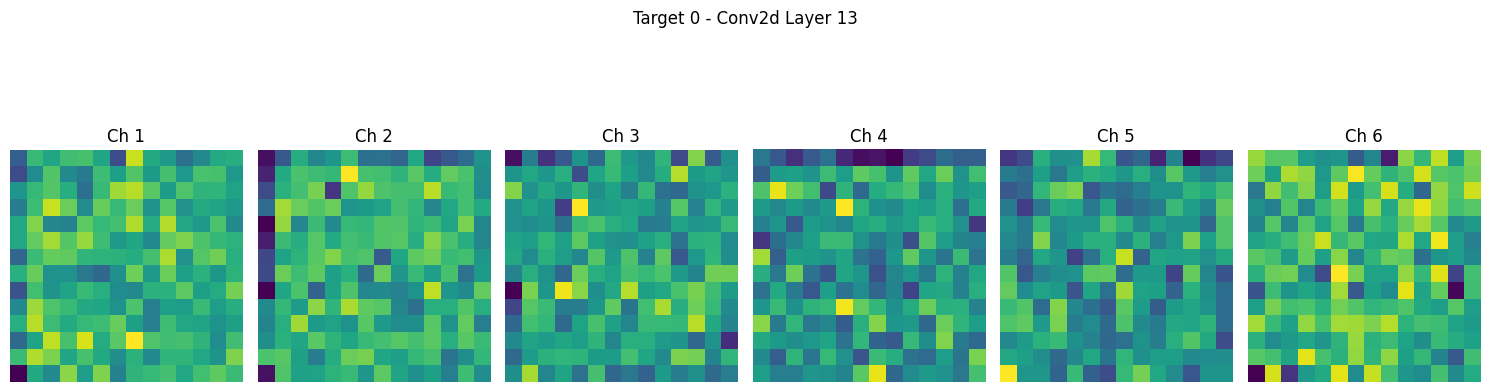

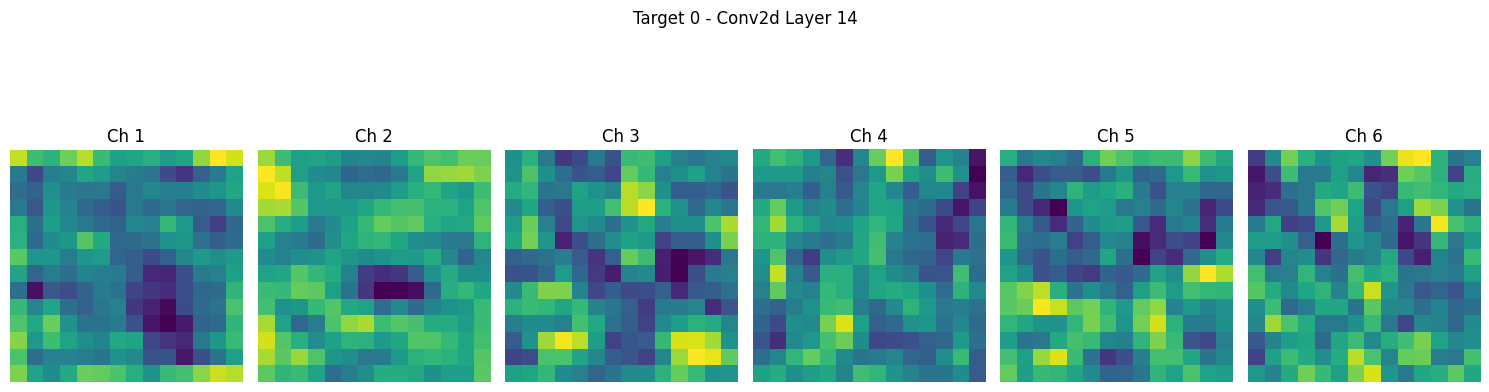

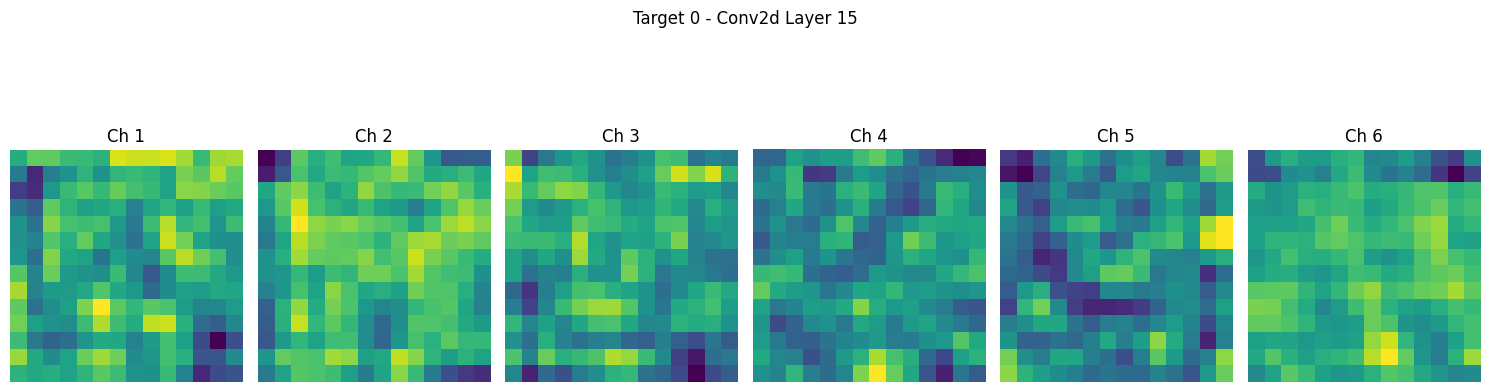

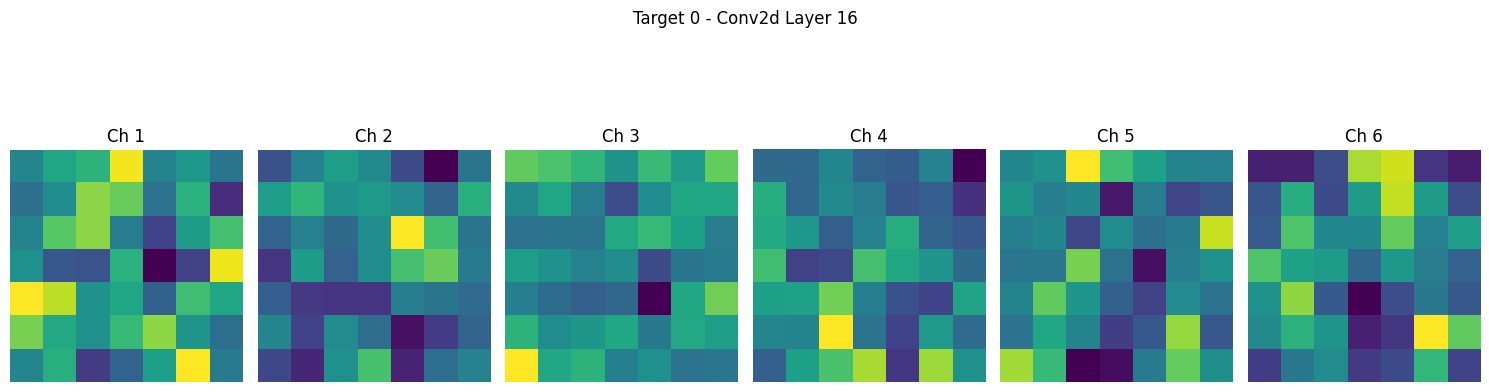

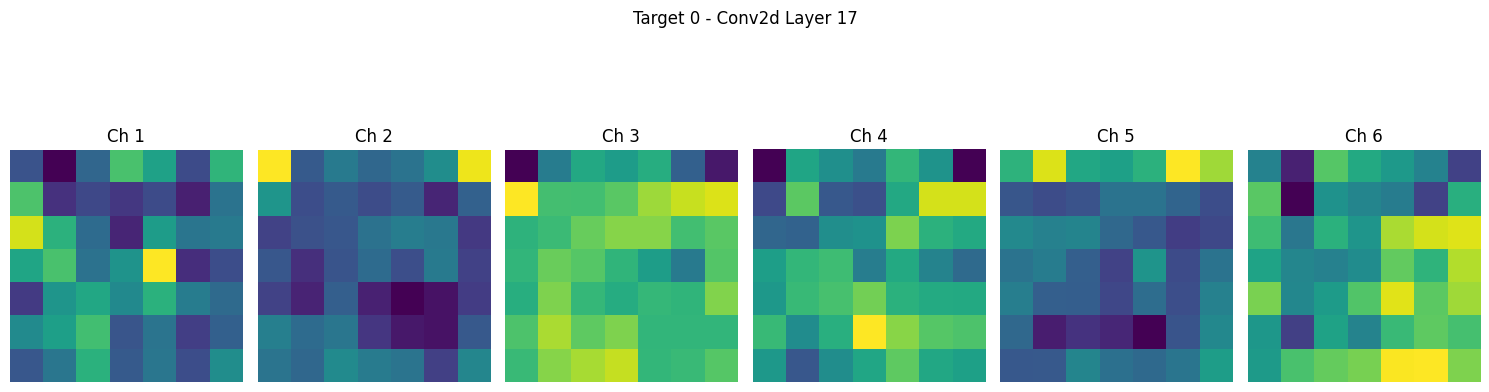

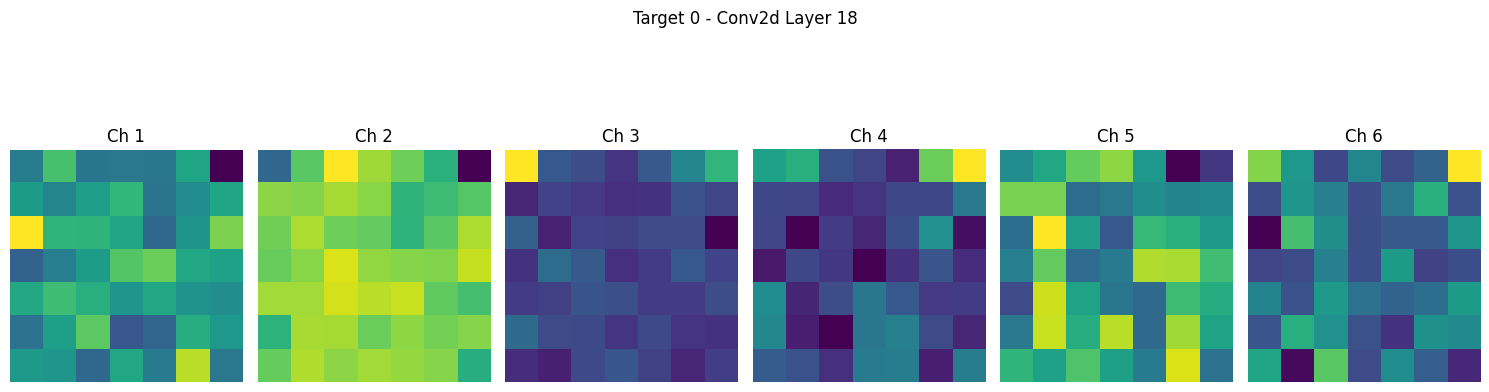

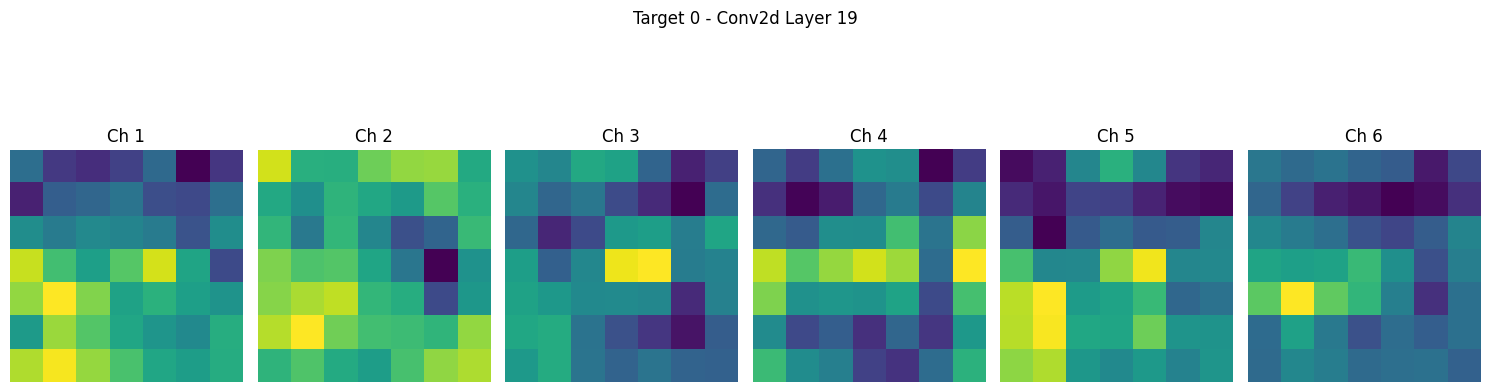

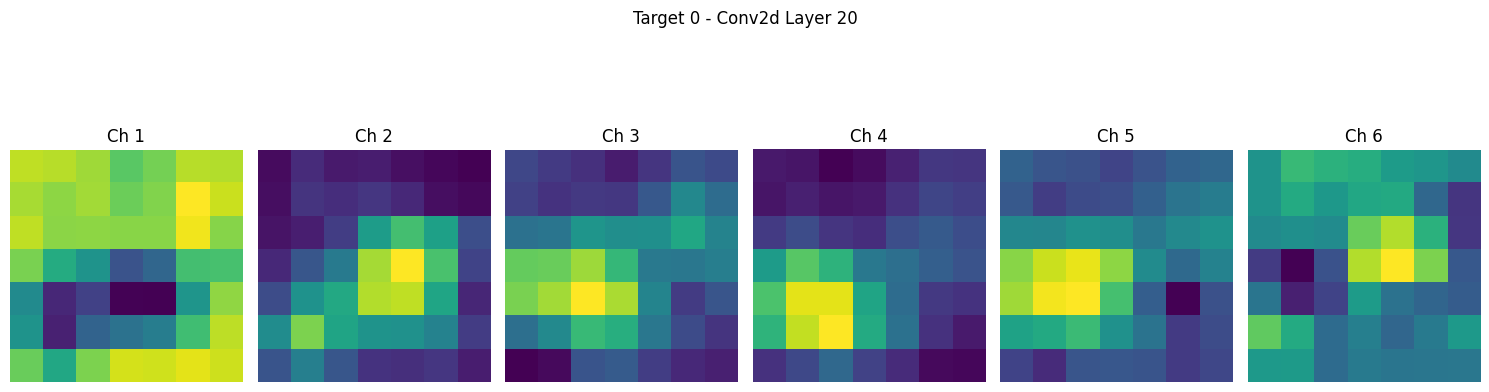

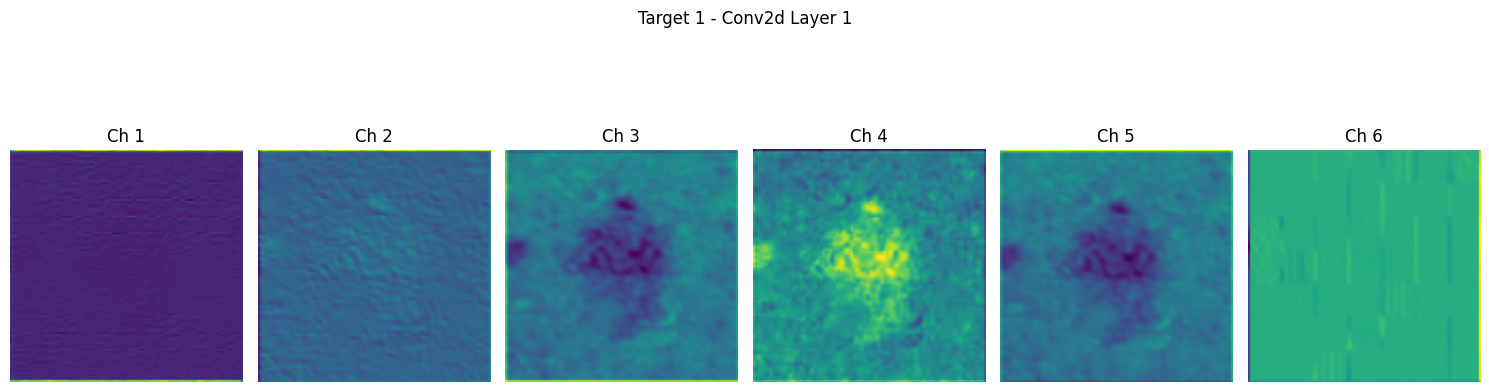

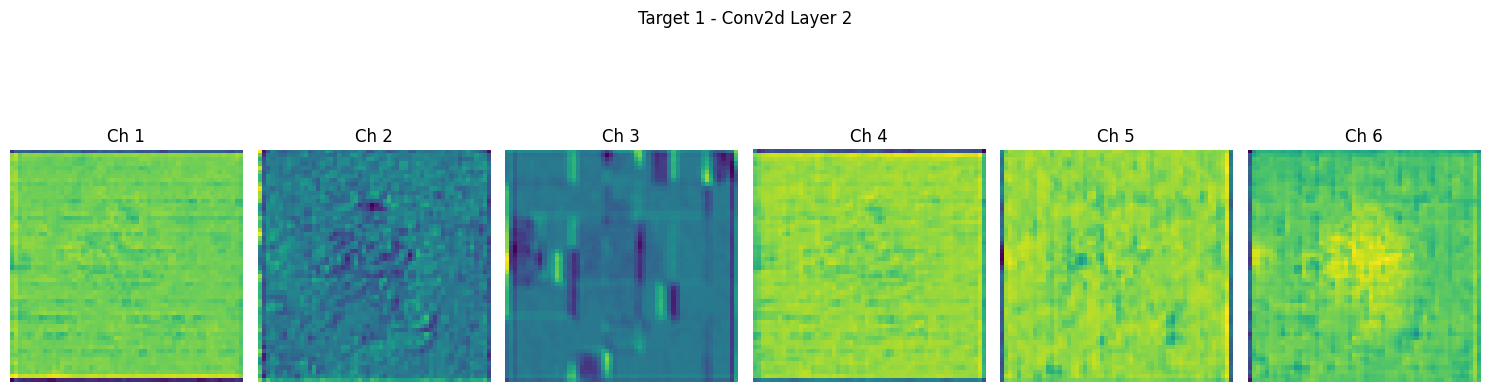

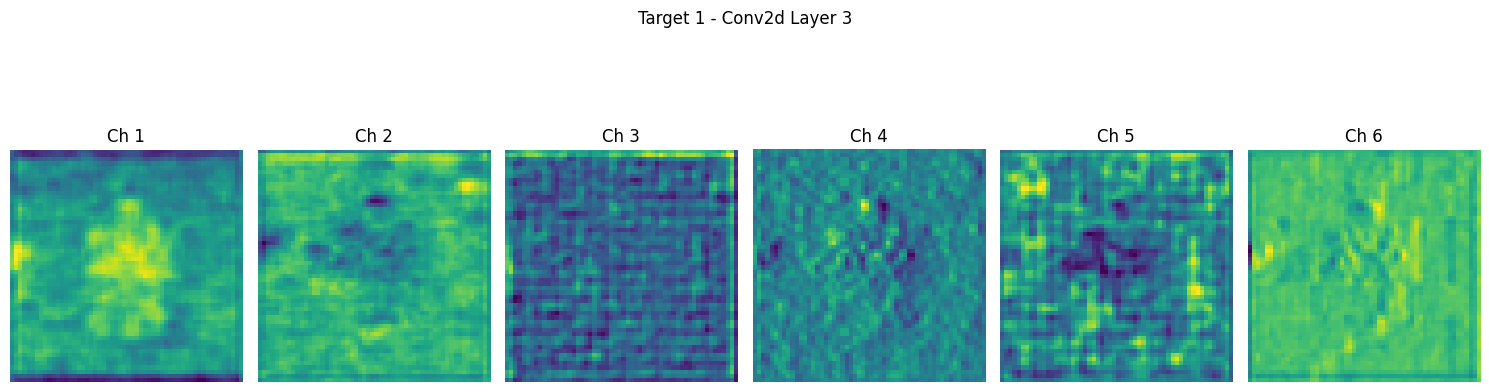

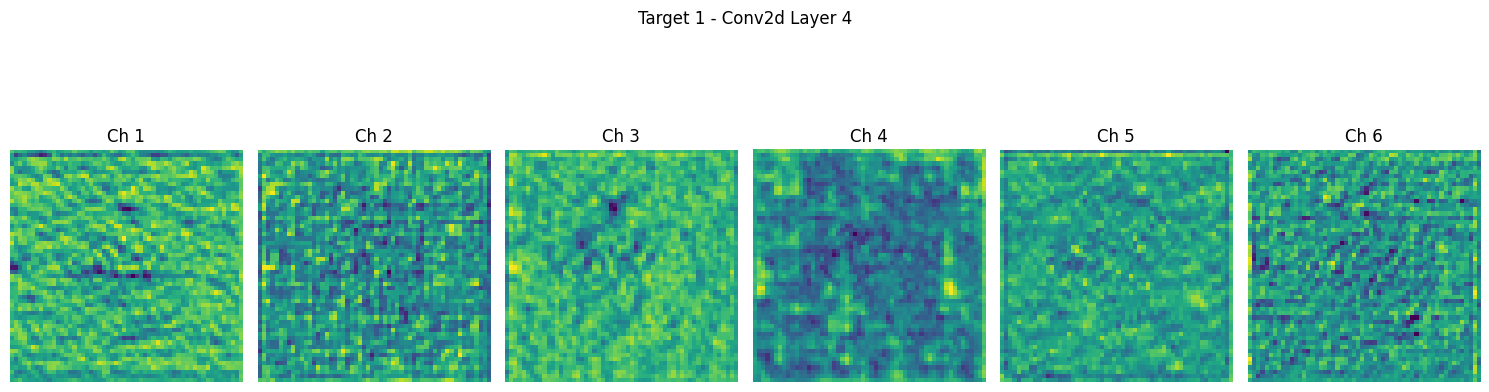

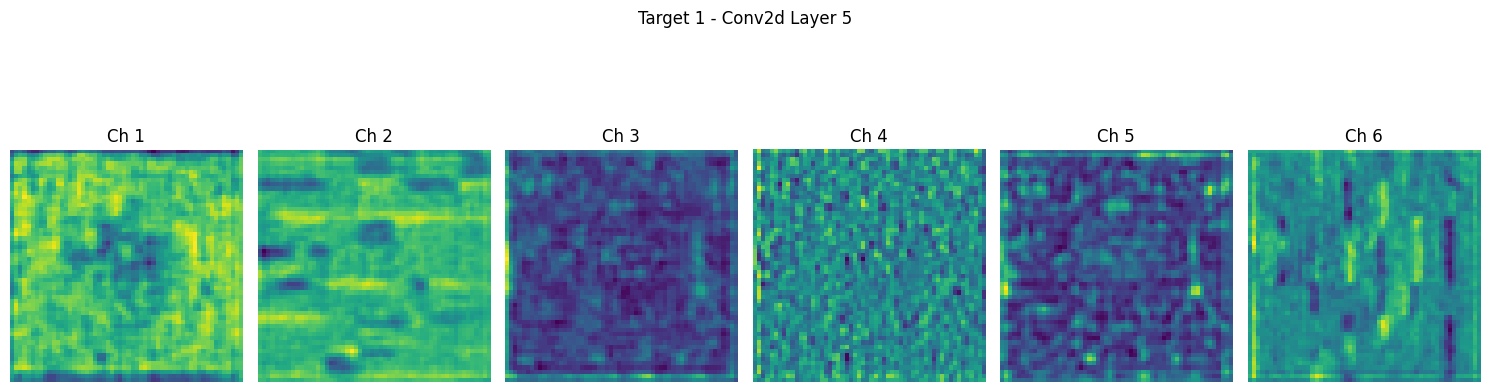

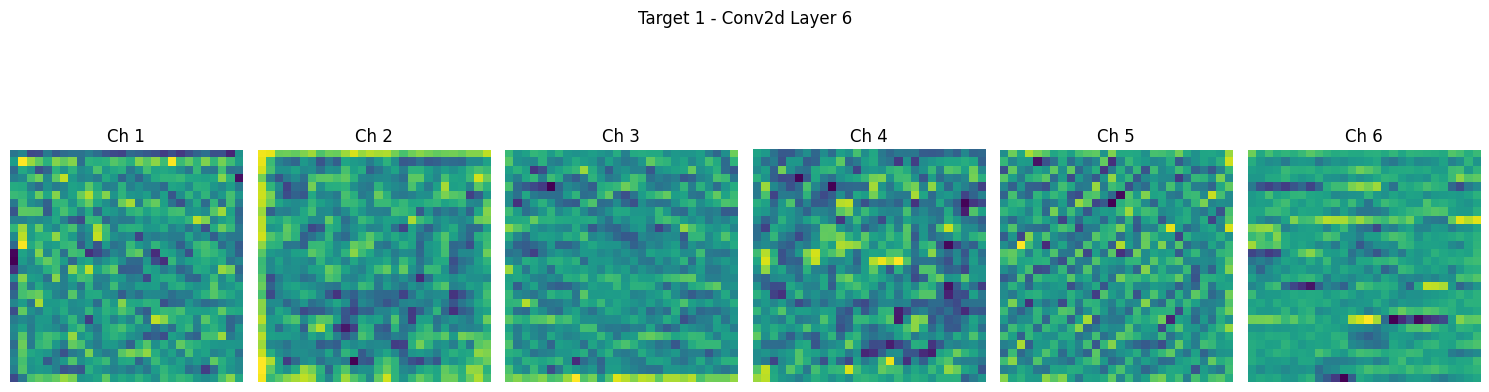

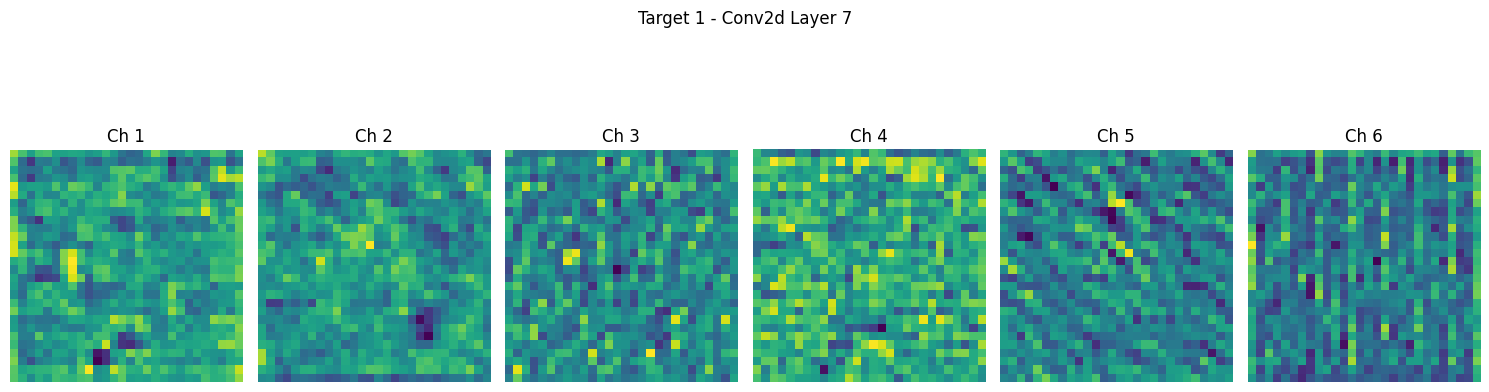

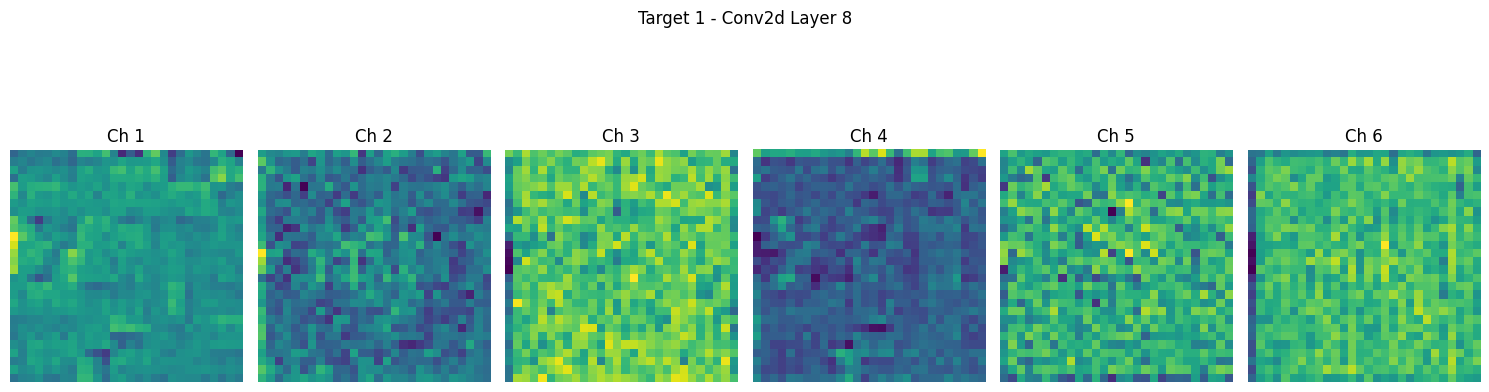

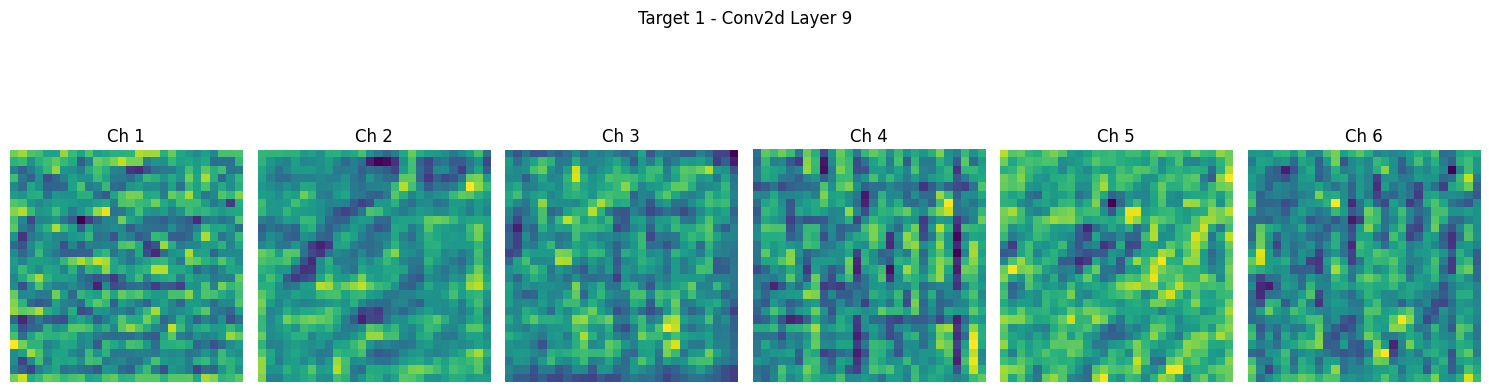

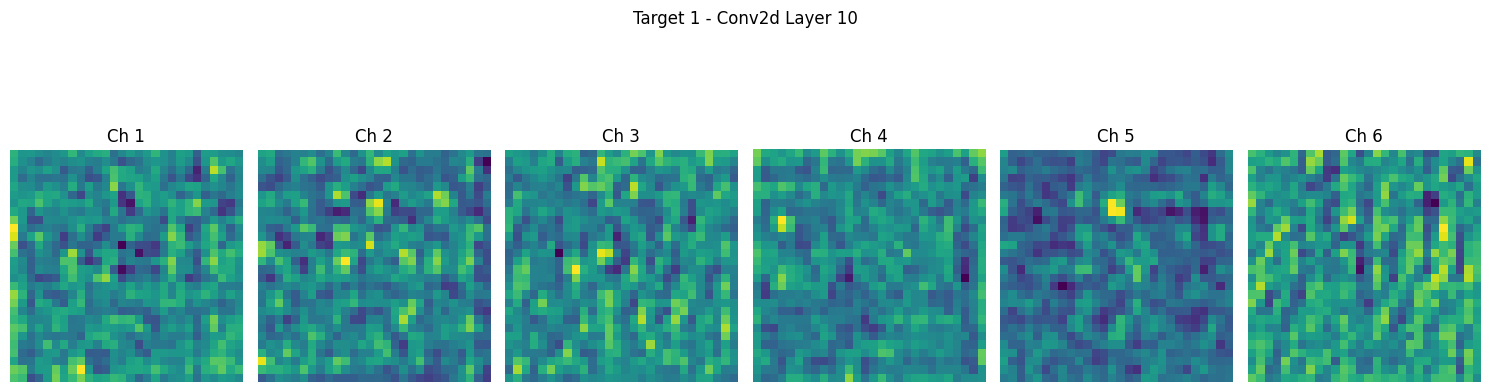

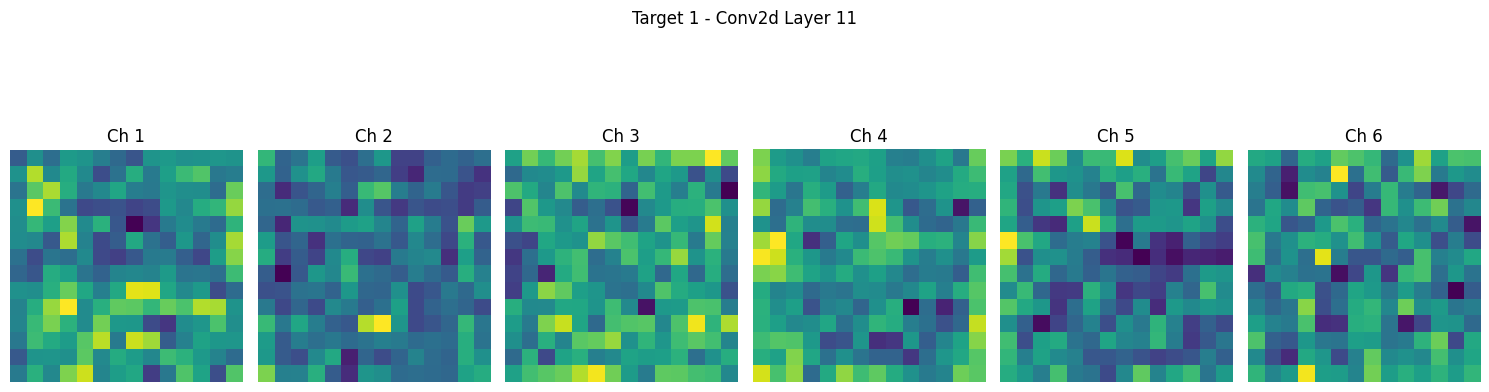

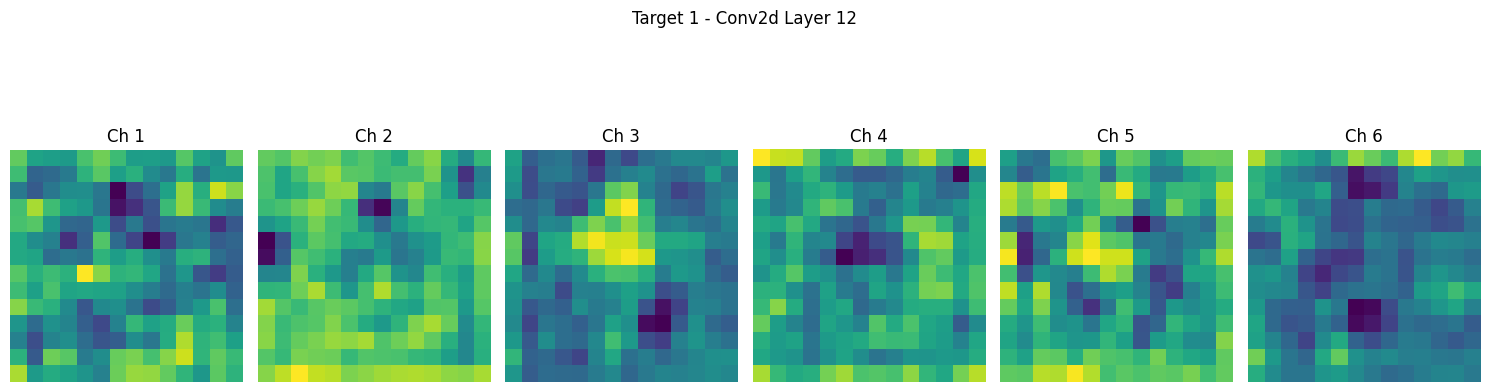

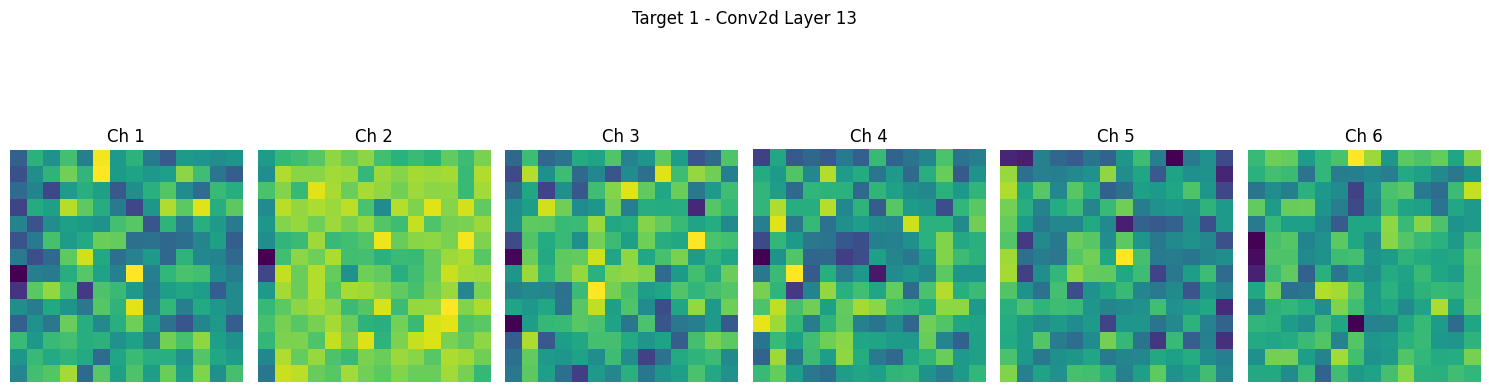

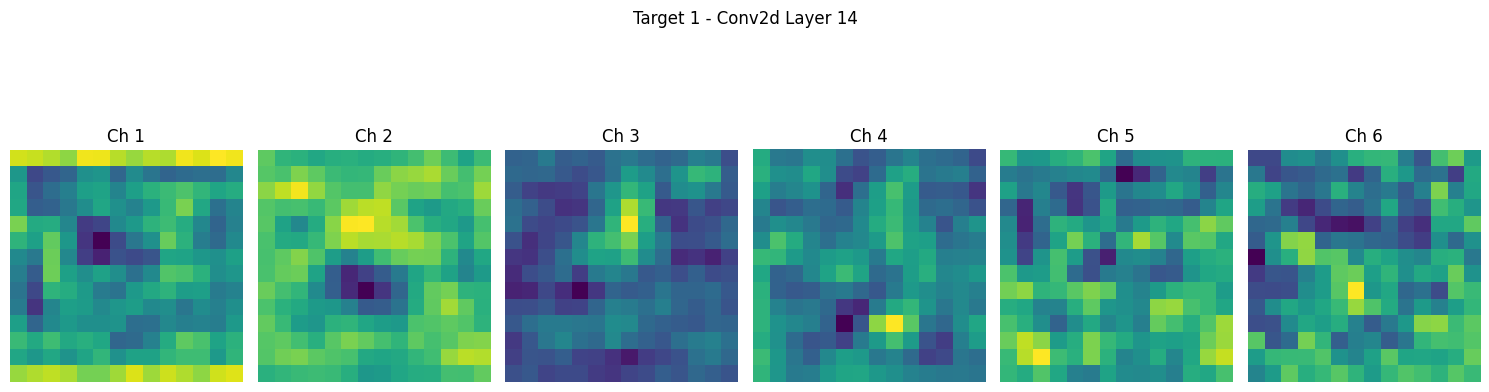

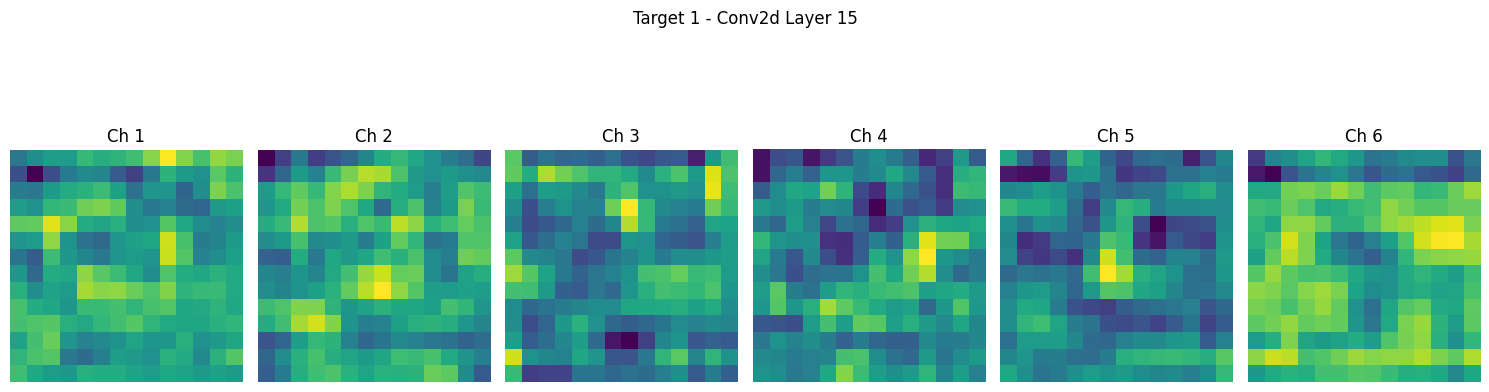

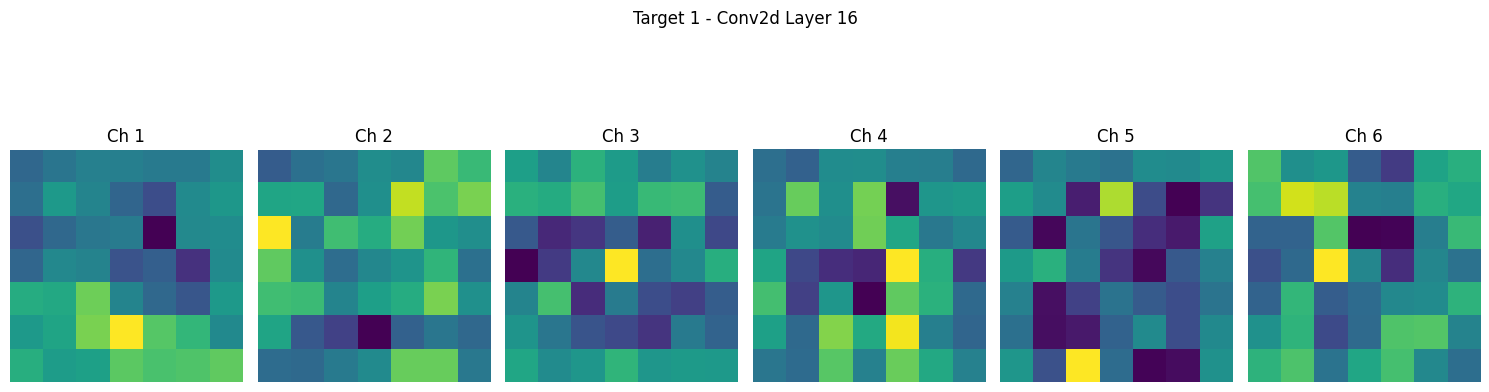

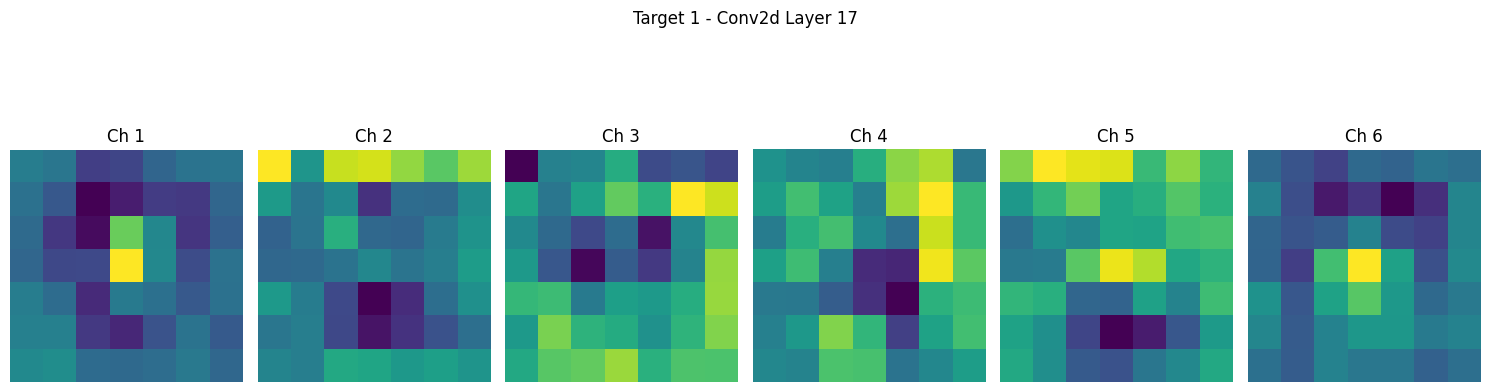

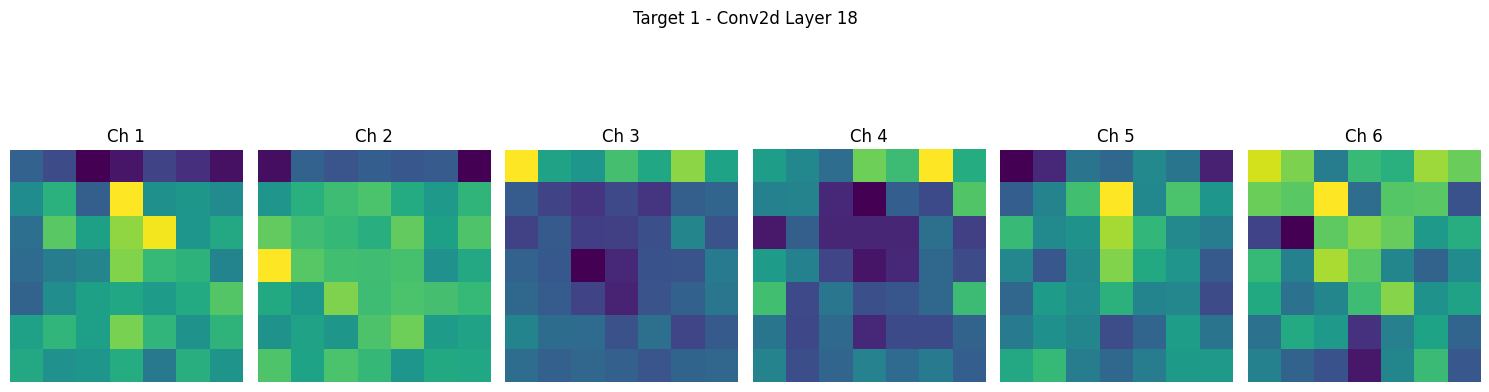

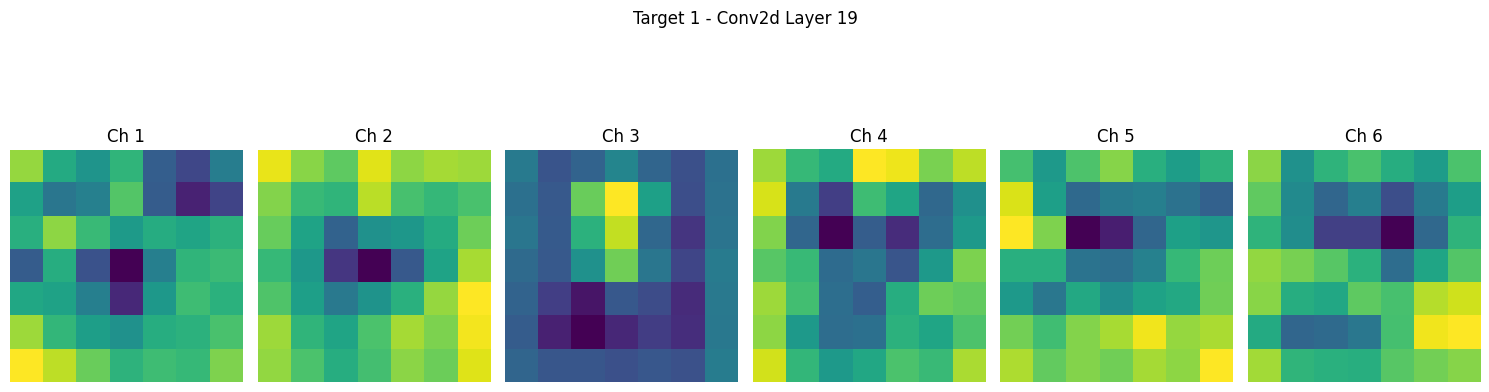

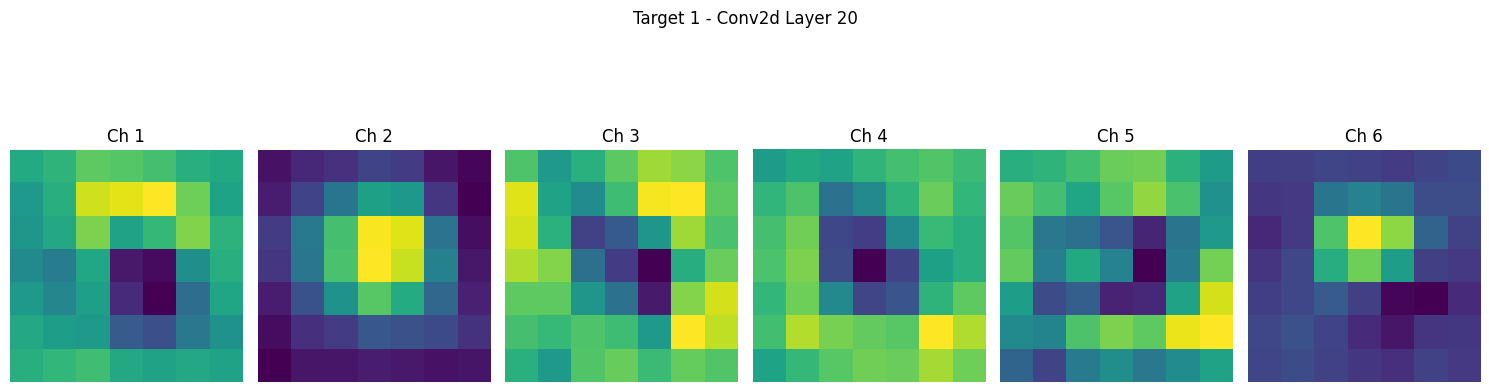

In [180]:
def plot_feature_maps(activations, conv_layers, sample_label):
    """
    Plots up to 6 feature map channels for each convolutional layer.
    """
    for i, activation in enumerate(activations):
        # Create a generic layer name since PyTorch doesn't have built-in names
        layer_name = f"Conv2d Layer {i+1}"
        
        # Convert tensor to numpy array if it's not already
        if torch.is_tensor(activation):
            activation = activation.detach().cpu().numpy()
            
        n_features = activation.shape[1]  # Channel dimension is typically second in PyTorch
        # Limit the number of channels plotted (here 6)
        n_channels_to_show = min(n_features, 6)
        
        # Get the activation maps
        activation_maps = activation[0, :n_channels_to_show]  # First sample, first n channels

        # Determine grid size: one row, n_channels columns
        fig, axes = plt.subplots(1, n_channels_to_show, figsize=(15, 5))
        
        # Handle case where there's only one channel
        if n_channels_to_show == 1:
            axes = [axes]
            
        for j in range(n_channels_to_show):
            # Use a colormap for activation maps
            axes[j].imshow(activation_maps[j], cmap='viridis')
            axes[j].axis('off')
            axes[j].set_title(f"Ch {j+1}")
        
        fig.suptitle(f"{sample_label} - {layer_name}")
        plt.tight_layout()
        plt.show()

# Assuming you have your activations stored in lists:
# activations_0 = [layer1_activations, layer2_activations, ...]
# activations_1 = [layer1_activations, layer2_activations, ...]
# conv_layers = [conv1, conv2, ...]

# Plot feature maps for target 0 image
plot_feature_maps(activations_0, conv_layers, "Target 0")

# Plot feature maps for target 1 image
plot_feature_maps(activations_1, conv_layers, "Target 1")

In [169]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pos_weight = torch.tensor([len(df_target1) / len(df_target0_sampled)]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward
        outputs = model(images)       # shape: (batch_size, 2)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate training metrics
        running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float().squeeze()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item() * images.size(0)
            
            predicted = (outputs > 0.5).float().squeeze()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/30] Train Loss: 0.0879, Train Acc: 0.9133, Val Loss: 0.2144, Val Acc: 0.8587
Epoch [2/30] Train Loss: 0.0937, Train Acc: 0.8984, Val Loss: 0.2200, Val Acc: 0.8522
Epoch [3/30] Train Loss: 0.0979, Train Acc: 0.9021, Val Loss: 0.1979, Val Acc: 0.8674
Epoch [4/30] Train Loss: 0.0687, Train Acc: 0.9301, Val Loss: 0.2012, Val Acc: 0.8543
Epoch [5/30] Train Loss: 0.0847, Train Acc: 0.9226, Val Loss: 0.2723, Val Acc: 0.8609
Epoch [6/30] Train Loss: 0.0985, Train Acc: 0.8966, Val Loss: 0.1801, Val Acc: 0.8543
Epoch [7/30] Train Loss: 0.0875, Train Acc: 0.9264, Val Loss: 0.2200, Val Acc: 0.8391
Epoch [8/30] Train Loss: 0.0756, Train Acc: 0.9292, Val Loss: 0.1913, Val Acc: 0.8413
Epoch [9/30] Train Loss: 0.0820, Train Acc: 0.9180, Val Loss: 0.2118, Val Acc: 0.8500
Epoch [10/30] Train Loss: 0.0755, Train Acc: 0.9366, Val Loss: 0.2090, Val Acc: 0.8500
Epoch [11/30] Train Loss: 0.0923, Train Acc: 0.9105, Val Loss: 0.2045, Val Acc: 0.8413
Epoch [12/30] Train Loss: 0.0788, Train Acc: 0.9152,

KeyboardInterrupt: 

In [ ]:
weights = model.fc[0].weight.data  # Shape: [hidden_units, num_features]

# Compute feature importance
feature_importance = torch.sum(torch.abs(weights), dim=0).cpu().numpy().flatten()

print("Number of features (processed.columns):", len(processed.columns))
print("Length of feature_importance:", feature_importance.shape[0])

# Create DataFrame (ensure processed.columns matches weights.shape[1])
importance_df = pd.DataFrame({
    'feature': list(processed.columns),  # Convert to list
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(30))

ValueError: All arrays must be of the same length